### Base settings

In [14]:
%load_ext autoreload
%autoreload 2

import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar100.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [16]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name / summary
checkpoint_path = log_root / 'checkpoints'

In [17]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

def initialize_vit_model(config, verbose=0):
    assert config.model.pretrained, 'only pretrained models are allowed'
    if config.model.pretrained:
        model = torch.hub.load(
            repo_or_dir=config.model.repo,
            model=config.model.pretrained_model,
            pretrained=True,
        )
    model = model.to(device=device)
    if verbose:
        print(model)
        
    return model

In [18]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, Dataset

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
]) 

cifar100 = CIFAR100(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
id_test_dataloader = DataLoader(
    dataset=cifar100, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

cifar10 = CIFAR10(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
ood_test_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

print(cifar10.class_to_idx)
print(cifar100.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, '

### Utility

In [29]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed = 1234

### Visualize features

In [20]:
import cv2

def apply_mask_on_img(img, mask):
    img_h, img_w, _ = img.shape
    mask = cv2.resize(mask, (img_h, img_w), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    masked_img = img * (1 - mask)
    return masked_img

In [21]:
from ood_with_vit.simmim import SimMIMHooker
from ood_with_vit.visualizer.feature_extractor import FeatureExtractor

model = initialize_vit_model(config)
simmim = SimMIMHooker(
    config=config,
    model=model,
    patch_embedding_layer_name='patch_embed.norm',
    mask_ratio=0.0,
)
simmim.hook()

# add hooks for feature extraction
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


name: patch_embed.norm


In [22]:
# gather penultimate features
from ood_with_vit.utils import compute_penultimate_features

set_seed(1234)
num_samples = 20
num_class = 10

print('processing in-distribution samples...')
X_in, y_in = [], []
in_img_paths = []
cls_indices = random.sample(range(len(cifar100.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(cifar100.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = cifar100[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_in.append(penultimate_features.squeeze().numpy())
        y_in.append((cls_idx, cifar100.classes[cls_idx]))
        # CHW => HWC
        original_img_path = f'./assets/cifar100/test/{i:05d}.jpg'
        original_img = cv2.imread(original_img_path)
        mask = simmim.get_mask()
        masked_img = apply_mask_on_img(original_img, mask)
        masked_img_path = f'./assets/cifar100/test/masked/{i:05d}.jpg'
        cv2.imwrite(masked_img_path, masked_img)
        in_img_paths.append(masked_img_path)

print('processing out-of-distribution samples...')
X_out, y_out = [], []
out_img_paths = []
cls_indices = random.sample(range(len(cifar10.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(cifar10.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = cifar10[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_out.append(penultimate_features.squeeze().numpy())
        y_out.append((cls_idx, cifar10.classes[cls_idx]))
        # CHW => HWC
        original_img_path = f'./assets/cifar10/test/{i:05d}.jpg'
        original_img = cv2.imread(original_img_path)
        mask = simmim.get_mask()
        masked_img = apply_mask_on_img(original_img, mask)
        masked_img_path = f'./assets/cifar10/test/masked/{i:05d}.jpg'
        cv2.imwrite(masked_img_path, masked_img)
        out_img_paths.append(masked_img_path)

processing in-distribution samples...


100%|██████████| 20/20 [00:00<00:00, 97.00it/s]


processing out-of-distribution samples...


100%|██████████| 20/20 [00:00<00:00, 96.94it/s]


#### Feature visualization by T-SNE

In [23]:
from ipywidgets import HTML, VBox

def interactive_plot(partitioned_info, fig, event="click") :
    """
    Make a plot react on hover or click of a data point and update a HTML preview below it.    
    """
    html = HTML("")
    fig = go.FigureWidget(data=fig.data, layout=fig.layout)

    if event == "hover" :
        for data in fig.data:
            def update(trace, points, state):
                if len(points.point_inds) == 0:
                    return
                trace_idx, point_idx = points.trace_index, points.point_inds[0]
                df_row = partitioned_info[trace_idx].iloc[point_idx]
                img_url = df_row['img']
                label = df_row['label']
                html.value = f'\
                    <body>\
                        <img src="{img_url}" width="240"><br>\
                        <b>Image: {img_url}</b><br>\
                        <b>Label: {label}</b>\
                    </body>'
            data.on_hover(update)
    else :
        for data in fig.data:
            def update(trace, points, state):
                if len(points.point_inds) == 0:
                    return
                trace_idx, point_idx = points.trace_index, points.point_inds[0]
                df_row = partitioned_info[trace_idx].iloc[point_idx]
                img_url = df_row['img']
                label = df_row['label']
                html.value = f'\
                    <body>\
                        <img src="{img_url}" width="240"><br>\
                        <b>Image: {img_url}</b><br>\
                        <b>Label: {label}</b>\
                    </body>'
            data.on_click(update)

    return VBox([fig, html])

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_in)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_in)
df_embed = df_embed.assign(img=in_img_paths)

partitioned_info, processed_labels = [], []
for label in y_in:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())

fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR100 T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/cifar100/test/masked/01191.jpg'],
…

In [26]:
tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_out)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_out)
df_embed = df_embed.assign(img=out_img_paths)

partitioned_info, processed_labels = [], []
for label in y_out:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained, CIFAR100 finetuned ViT CIFAR10 T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/cifar10/test/masked/02593.jpg'],
 …

#### Feature visualization by PCA

In [27]:
from sklearn.decomposition import PCA

pca = PCA()
components = pca.fit_transform(X_in)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_in)
df_embed = df_embed.assign(img=in_img_paths)

partitioned_info, processed_labels = [], []
for label in y_in:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())

fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained, CIFAR100 finetuned ViT CIFAR100 PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/cifar100/test/masked/01191.jpg'],
…

In [28]:
pca = PCA()
components = pca.fit_transform(X_out)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_out)
df_embed = df_embed.assign(img=out_img_paths)

partitioned_info, processed_labels = [], []
for label in y_out:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained, CIFAR100 finetuned ViT CIFAR10 PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/cifar10/test/masked/02593.jpg'],
 …

### OOD detection after SimMIM masking applied

In [64]:
from ood_with_vit.utils import compute_ood_scores
from ood_with_vit.utils.ood_metrics import auroc, aupr, fpr_at_95_tpr
from ood_with_vit.utils.visualization import plot_roc_curve, plot_precision_recall_curve

# mask_ratio = 0.1

#### OOD detection by MSP (Maximum over Softmax Probability)

In [51]:
from ood_with_vit.metrics.msp import MSP

model = initialize_vit_model(config)
msp = MSP(config, model)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): 

In [53]:
# hook mask_patch
simmim = SimMIMHooker(
    config=config,
    model=model,
    patch_embedding_layer_name='patch_embed.norm',
    mask_ratio=mask_ratio,
)
simmim.hook()

test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=msp,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores))

name: patch_embed.norm
processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 15.67it/s]

id mean score: -0.452411
ood mean score: -0.4043067


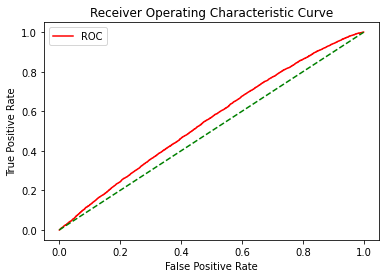

MSP AUROC score: 0.5520875199999999


In [54]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('MSP AUROC score:', auroc_score)

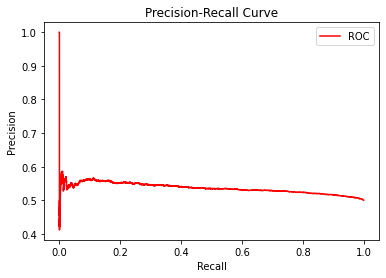

MSP AUPR score: 0.5359905928383172


In [55]:
precision, recall, aupr_score = aupr(test_y, ood_scores)
# aupr_score = average_precision_score(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('MSP AUPR score:', aupr_score)

In [56]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('MSP fpr95 score:', fpr95)

MSP fpr95 score: 0.911


### OOD detection by Mahalanobis

In [58]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis
from ood_with_vit.visualizer.feature_extractor import FeatureExtractor

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar100 = CIFAR100(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar100, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
mahalanobis = Mahalanobis(config, model, id_train_dataloader, feature_extractor)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): 

100%|██████████| 98/98 [00:24<00:00,  4.01it/s]


covariance norm: 14.235700347525052


In [67]:
# hook mask_patch
simmim = SimMIMHooker(
    config=config,
    model=model,
    patch_embedding_layer_name='patch_embed.norm',
    mask_ratio=mask_ratio,
)
simmim.hook()

test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

name: patch_embed.norm
processing in-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 13.37it/s]

id mean score: 431.40994 id variance: 3739.0176
ood mean score: 448.1536 ood variance: 2906.0715


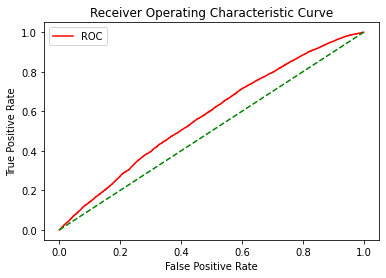

Mahalanobis AUROC score: 0.5781248


In [68]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

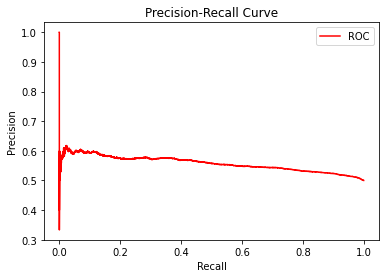

Mahalanobis AUPR score: 0.5572917568617607


In [69]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [70]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.8925


In [71]:
from ood_with_vit.metrics.sml import SML

model = initialize_vit_model(config)
sml = SML(config, model, id_train_dataloader)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): 

100%|██████████| 98/98 [00:25<00:00,  3.84it/s]


In [77]:
# hook mask_patch
simmim = SimMIMHooker(
    config=config,
    model=model,
    patch_embedding_layer_name='patch_embed.norm',
    mask_ratio=mask_ratio,
)
simmim.hook()

test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=sml,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

name: patch_embed.norm
processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


id mean score: 4.8796208895918625 id variance: 1.9578902844789732
ood mean score: 5.204622194300016 ood variance: 1.628932299108642


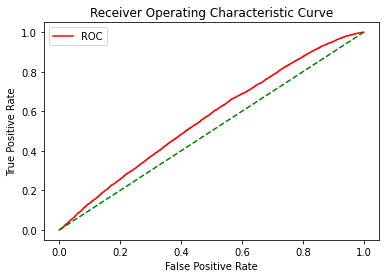

SML AUROC score: 0.5645693649999999


In [78]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('SML AUROC score:', auroc_score)

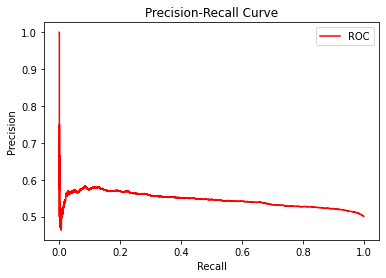

SML AUPR score: 0.5449248125463708


In [79]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('SML AUPR score:', aupr_score)

In [80]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('SML fpr95 score:', fpr95)

SML fpr95 score: 0.8959
